# **Predicting probability of default (PD) with logistic regression and random forest**

**Table of contents**      
  - **Libraries**    
  - **Reading and cleaning the data**    
    - Variables' description
    - Removing duplicates    
    - Inspecting missing values    
  - **Exploratory analysis**    
    - Plotting distributions    
    - Inspecting personal income    
    - Inspecting loan grade    
  - **Modeling part**    
    - Splitting the data into the training and test set    
    - Creating dummy variables    
    - Logistic regression model formula    
      - Prediction    
      - Classification report    
      - No information rate    
    - Random forest model formula    
      - Prediction    
      - Classification report    
      - No information rate and accuracy score    
    - Feature Importance    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=false
	flat=false
	minLevel=1
	maxLevel=4
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Libraries

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import classification_report,roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

## Reading and cleaning the data

In [106]:
df = pd.read_csv('credit_risk_dataset.csv')

In [107]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.00,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.00,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.00,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.00,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.00,MEDICAL,C,35000,14.27,1,0.55,Y,4


### Variables' description:
1. person_age	Age
2. person_income	Annual Income
3. person_home_ownership	Home ownership
4. person_emp_length	Employment length (in years)
5. loan_intent	Loan intent
6. loan_grade	Loan grade
7. loan_amnt	Loan amount
8. loan_int_rate	Interest rate
9. loan_status	Loan status (0 is non default 1 is default)
10. loan_percent_income	Percent income
11. cb_person_default_on_file	Historical default
12. cb_preson_cred_hist_length	Credit history length

#### There are 165 duplicates in the dataset

In [108]:
len(df[df.duplicated()])

165

### Removing duplicates

In [109]:
df[df.duplicated()].index

Index([15975, 15989, 15995, 16025, 16028, 16038, 16065, 16070, 16079, 16091,
       ...
       29090, 29100, 29109, 29113, 31947, 32010, 32047, 32172, 32259, 32279],
      dtype='int64', length=165)

In [110]:
df = df.drop(index=df[df.duplicated()].index)

In [111]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.00,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.00,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.00,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.00,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.00,MEDICAL,C,35000,14.27,1,0.55,Y,4


### Inspecting missing values

In [112]:
df.isna().sum().sort_values(ascending=False)

loan_int_rate                 3095
person_emp_length              887
person_income                    0
person_age                       0
person_home_ownership            0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [113]:
df_missing = pd.DataFrame(df.isna().sum()/len(df)).reset_index()
df_missing.columns = ['variable','nan_share']

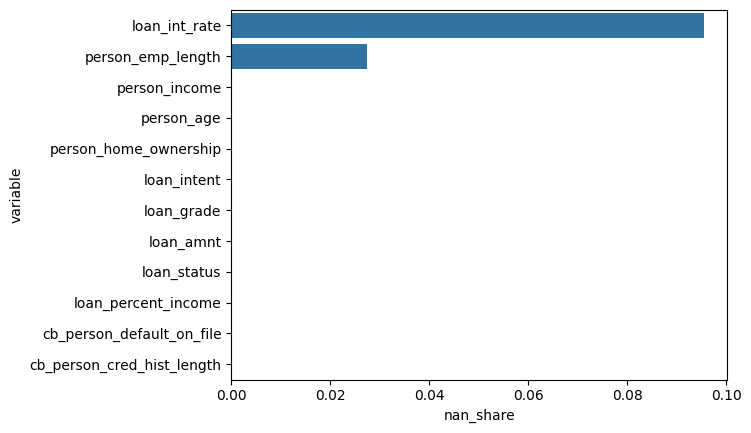

In [114]:
sns.barplot(df_missing.sort_values('nan_share',ascending=False),
            y = 'variable',
            x = 'nan_share')
plt.show()

##### It was decided to remove the missing values

In [115]:
df = df.dropna()

In [116]:
len(df)

28501

In [117]:
np.sum(df.isna().sum())

np.int64(0)

## Exploratory analysis

### Plotting distributions

##### There are people that are over 100 years old and people who have been employed for over 100 years which indicates that there are issues with the data and such rows will be removed. Personal income is also a problematic variable, as there are (allegedly) people that earn more than 1 000 000

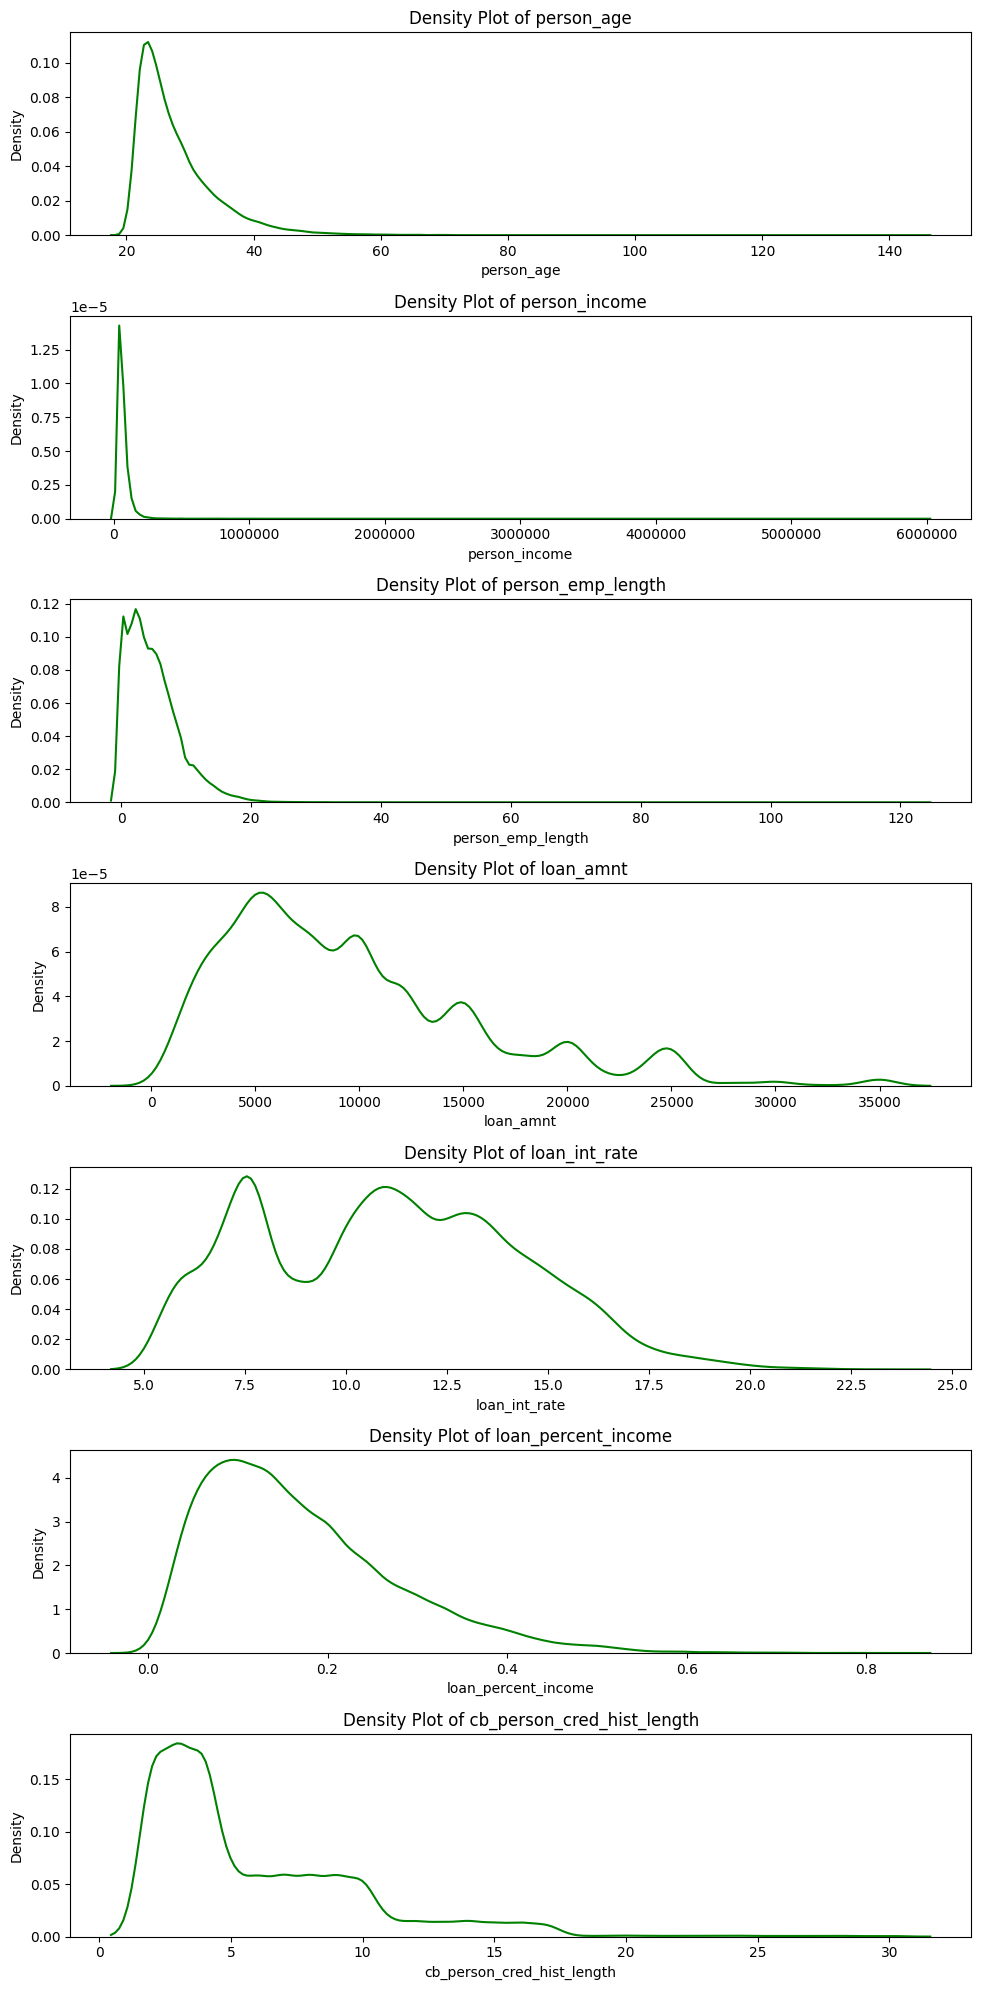

In [118]:
fig,axes = plt.subplots(ncols = 1, nrows = 7, figsize= (10,20))
axes = axes.flatten()

for ind, col in enumerate(df.loc[:,df.columns.isin(["person_age","person_income","person_emp_length","loan_amnt","loan_int_rate","loan_percent_income","cb_person_cred_hist_length"])].columns.to_list()):
    sns.kdeplot(data=df,x=col,color="green",ax = axes[ind])
    axes[ind].set_title(f'Density Plot of {col}')
    axes[ind].ticklabel_format(style='plain', axis='x')

plt.tight_layout()    
plt.show()

In [119]:
df.select_dtypes(np.number).describe().round(2).iloc[1:,:]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
mean,27.74,66654.41,4.79,9658.53,11.05,0.22,0.17,5.80
std,6.32,62376.03,4.16,6329.60,3.23,0.41,0.11,4.04
min,20.00,4000.00,0.00,500.00,5.42,0.00,0.00,2.00
25%,23.00,39500.00,2.00,5000.00,7.90,0.00,0.09,3.00
50%,26.00,56000.00,4.00,8000.00,10.99,0.00,0.15,4.00
75%,30.00,80000.00,7.00,12500.00,13.48,0.00,0.23,8.00
max,144.00,6000000.00,123.00,35000.00,23.22,1.00,0.83,30.00


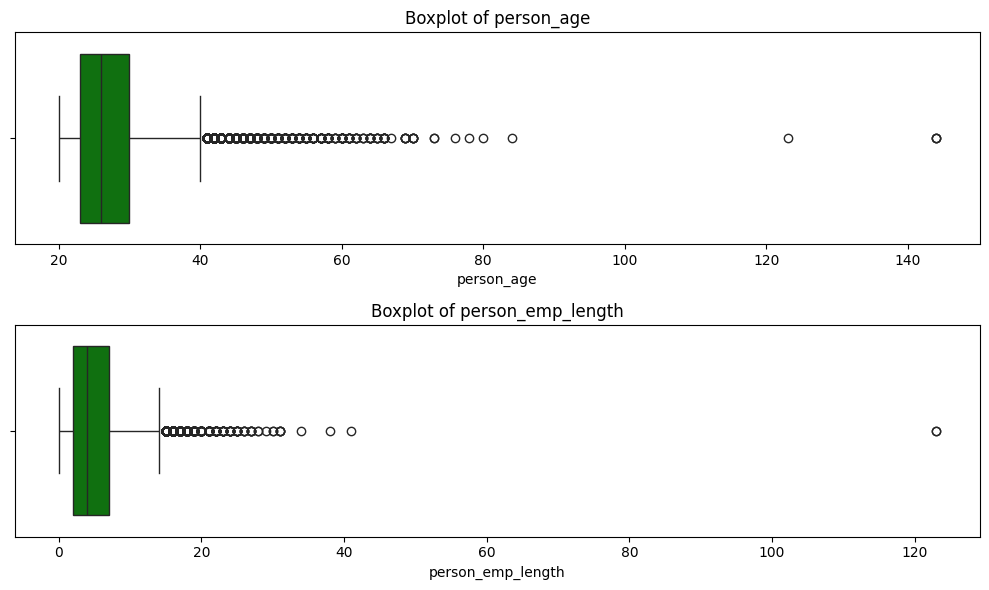

In [120]:
fig,axes = plt.subplots(ncols = 1, nrows = 2, figsize= (10,6))
axes = axes.flatten()

for ind, col in enumerate(df.loc[:,df.columns.isin(["person_age","person_emp_length"])].columns.to_list()):
    sns.boxplot(data=df,x=col,color="green",ax = axes[ind])
    axes[ind].set_title(f'Boxplot of {col}')

plt.tight_layout()    
plt.show()

In [121]:
df[df['person_age'] > 100]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.00,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.00,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.00,EDUCATION,B,20400,10.25,0,0.25,N,3
32297,144,6000000,MORTGAGE,12.00,PERSONAL,C,5000,12.73,0,0.00,N,25


In [122]:
df[df['person_age'] > 100].index

Index([81, 183, 575, 32297], dtype='int64')

In [123]:
df.drop(index=df[df['person_age'] > 100].index,inplace=True)

In [124]:
df[df['person_emp_length']>100]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.00,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.00,VENTURE,A,20000,6.54,0,0.10,N,4


In [125]:
df.drop(index=df[df['person_emp_length']>100].index,inplace=True)

### Inspecting personal income

In [126]:
pd.options.display.float_format = '{:.2f}'.format
df['person_income'].describe()

count     28495.00
mean      66430.47
std       51513.74
min        4000.00
25%       39480.00
50%       56000.00
75%       80000.00
max     2039784.00
Name: person_income, dtype: float64

In [127]:
percentiles = df['person_income'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1])

print(percentiles)

0.10     29000.00
0.20     36000.00
0.30     42000.00
0.40     49621.00
0.50     56000.00
0.60     64000.00
0.70     74000.00
0.80     87000.00
0.90    112000.00
0.91    116400.00
0.92    120000.00
0.93    125000.00
0.94    130000.00
0.95    140000.00
0.96    150000.00
0.97    160000.00
0.98    185000.00
0.99    230000.00
1.00   2039784.00
Name: person_income, dtype: float64


##### Displaying data where the personal income variable is above the 99th percentile

In [128]:
df[df['person_income']>230004.00].head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15,23,500000,MORTGAGE,7.00,DEBTCONSOLIDATION,B,30000,10.65,0,0.06,N,3
33,25,306000,RENT,2.00,DEBTCONSOLIDATION,C,24250,13.85,0,0.08,N,3
34,26,300000,MORTGAGE,10.00,MEDICAL,C,7800,13.49,0,0.03,N,4
42,26,300000,MORTGAGE,10.00,VENTURE,A,20000,7.88,0,0.07,N,4
43,23,300000,OWN,1.00,EDUCATION,F,24250,19.41,0,0.08,Y,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32308,51,260000,MORTGAGE,1.00,PERSONAL,A,14000,7.66,0,0.05,N,26
32497,63,1782000,RENT,13.00,EDUCATION,C,12025,14.27,0,0.01,N,30
32543,52,720000,MORTGAGE,1.00,PERSONAL,A,7925,8.94,0,0.01,N,30
32544,58,780000,MORTGAGE,7.00,PERSONAL,A,4500,6.91,0,0.01,N,20


##### It's difficult to say whether or not there are issues with all of the 285 rows but these rows were removed because such earnings contribute to very high residuals which wouldn't be opitmal for the later modeling part

In [129]:
df.drop(index = df[df['person_income']>230004.00].index, inplace=True)

##### Clients, whose loan_intent is categorized as debt consolidation, medical and homeimprovement are more likely to default on the credit

In [131]:
pd.crosstab(df['loan_intent'],df['loan_status'],margins=True,normalize='index').style.format("{:.0%}")

loan_status,0,1
loan_intent,,
DEBTCONSOLIDATION,71%,29%
EDUCATION,83%,17%
HOMEIMPROVEMENT,74%,26%
MEDICAL,73%,27%
PERSONAL,80%,20%
VENTURE,85%,15%
All,78%,22%


##### Clients, who already have defaulted previously are more likely to do it again

In [132]:
pd.crosstab(df['cb_person_default_on_file'],df['loan_status'],margins=True,normalize='index').style.format("{:.0%}")

loan_status,0,1
cb_person_default_on_file,,
N,82%,18%
Y,62%,38%
All,78%,22%


In [133]:
df_default_history = pd.crosstab(df['cb_person_default_on_file'],df['loan_status'],margins=True,normalize='index').iloc[0:2,:]

In [134]:
df_default_history

loan_status,0,1
cb_person_default_on_file,,
N,0.82,0.18
Y,0.62,0.38


##### The disproportion among clients who historically defaulted on a credit is much smaller than among clients who have not previously had a record of defualted credits

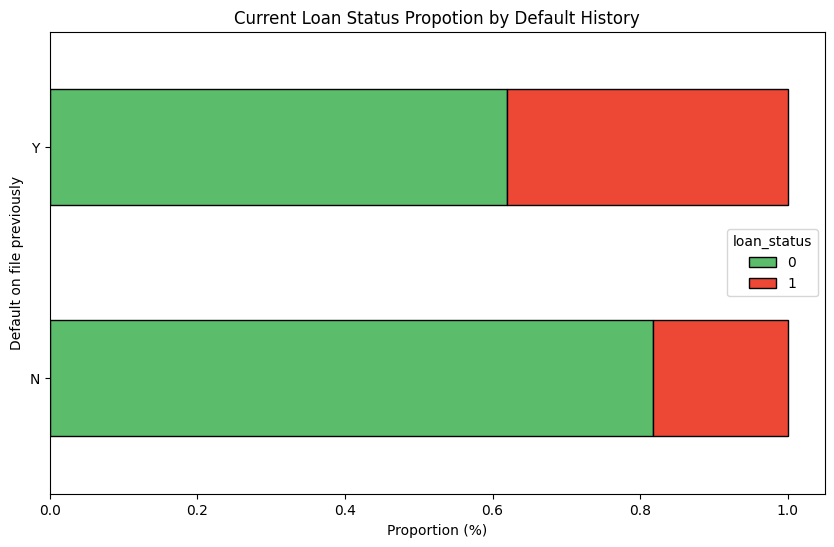

In [135]:
fig, ax = plt.subplots(figsize = (10, 6))

df_default_history.plot(kind = "barh",
        stacked = True,
        ax = ax,
        width = 0.5,
        edgecolor = "black",
        color= ['#5BBC6B','#ED4736'])
plt.xlabel("Proportion (%)")
plt.ylabel("Default on file previously")
plt.title("Current Loan Status Propotion by Default History")
plt.show()

### Inspecting loan grade

In [136]:
pd.crosstab(df['loan_grade'],df['loan_status'],margins=True)

loan_status,0,1,All
loan_grade,,,
A,8381,897,9278
B,7560,1445,9005
C,4464,1154,5618
D,1292,1904,3196
E,299,554,853
F,61,143,204
G,1,57,58
All,22058,6154,28212


In [137]:
df_loan_grade = pd.crosstab(df['loan_grade'],df['loan_status'],margins=True,normalize='index').iloc[:-1,:]

In [138]:
df_loan_grade

loan_status,0,1
loan_grade,,
A,0.90,0.10
B,0.84,0.16
C,0.79,0.21
D,0.40,0.60
E,0.35,0.65
F,0.30,0.70
G,0.02,0.98


In [139]:
pd.crosstab(df['loan_grade'],df['loan_status'],margins=True,normalize='index').iloc[-1:,:]

loan_status,0,1
loan_grade,,
All,0.78,0.22


##### Plotting loan grades by loan status

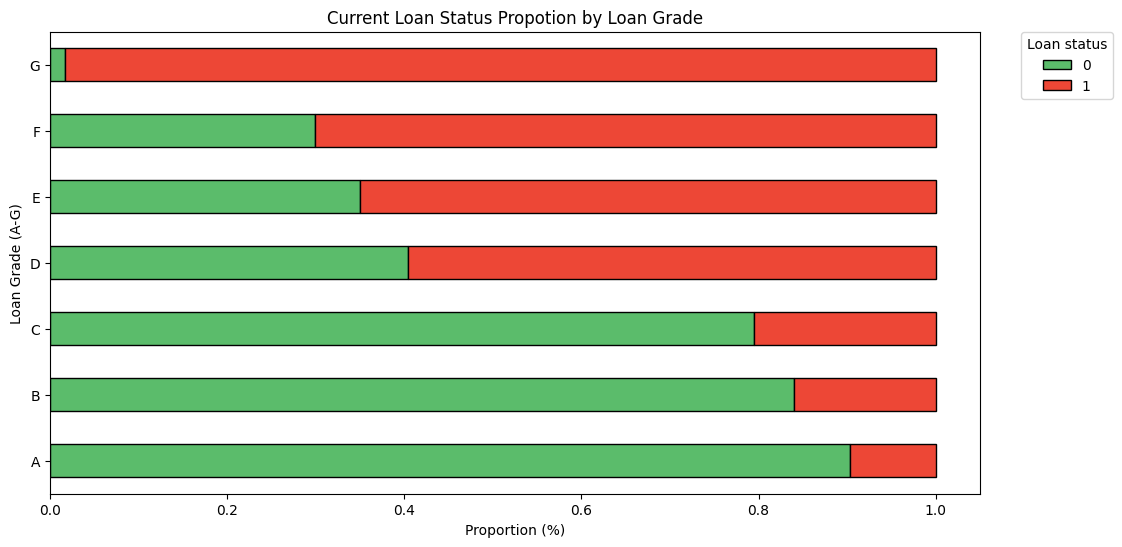

In [140]:
fig, ax = plt.subplots(figsize = (12, 6))

df_loan_grade.plot(kind = "barh",
        stacked = True,
        ax = ax,
        width = 0.5,
        edgecolor = "black",
        color= ['#5BBC6B','#ED4736'])
plt.xlabel("Proportion (%)")
plt.ylabel("Loan Grade (A-G)")
plt.title("Current Loan Status Propotion by Loan Grade")
plt.legend(bbox_to_anchor=(1.15,1.015),loc="upper right",title="Loan status")
plt.show()

##### It was decided to aggregate grades between D and G into "Other". Such manipulation was needed because nearly 100% of clients who were given the "G" rating have defaulted on a credit which would then result in having almost zero variance dummy variable

In [141]:
def loan_grade_fix(x):
    if x not in ["A","B","C"]:
        return "Other"
    else:
        return x

In [142]:
df['loan_grade'] = df['loan_grade'].apply(loan_grade_fix)

## Modeling part

### Splitting the data into the training and test set

In [143]:
X = df.drop(["loan_status"],axis=1)
y = df["loan_status"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=123)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (19748, 11)
X_test shape: (8464, 11)
y_train shape: (19748,)
y_test shape: (8464,)


### Creating dummy variables

In [144]:
X_train = pd.get_dummies(data=X_train,columns=X_train.select_dtypes('object').columns.to_list(),drop_first=True,dtype="int")
X_test = pd.get_dummies(data=X_test,columns=X_test.select_dtypes('object').columns.to_list(),drop_first=True,dtype="int")

In [145]:
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_Other,cb_person_default_on_file_Y
26965,30,120000,12.00,7200,9.99,0.06,9,0,0,0,0,0,0,0,0,1,0,0,0
15704,21,155800,2.00,18000,11.26,0.12,3,0,0,0,0,0,1,0,0,1,0,0,0
24401,29,72000,7.00,24000,7.88,0.33,9,0,0,0,0,0,1,0,0,0,0,0,0
24824,27,90000,3.00,10000,7.66,0.11,7,0,0,1,0,0,0,0,0,0,0,0,0
31206,37,80000,18.00,20000,11.83,0.25,13,0,0,0,0,0,1,0,0,1,0,0,0


### Logistic regression model formula

In [146]:
mod = sm.Logit(y_train,X_train).fit()
print(mod.summary())

Optimization terminated successfully.
         Current function value: 0.346766
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                19748
Model:                          Logit   Df Residuals:                    19729
Method:                           MLE   Df Model:                           18
Date:                Sun, 21 Jul 2024   Pseudo R-squ.:                  0.3397
Time:                        19:49:08   Log-Likelihood:                -6847.9
converged:                       True   LL-Null:                       -10370.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
person_age                     -0.1013      0.006    -16.373      0.000   

#### Prediction

In [147]:
def group(x):
    if x>=0.5:
        return 1
    else:
        return 0

In [148]:
y_test_pred = mod.predict(X_test).apply(group)

#### Classification report

In [149]:
print(classification_report(y_true = y_test, y_pred= y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6627
           1       0.77      0.53      0.63      1837

    accuracy                           0.86      8464
   macro avg       0.82      0.74      0.77      8464
weighted avg       0.86      0.86      0.85      8464



##### Classification report

Regarding group "0":
* precision = 0.88 implies that among all observations that were classified as "0" by the model, 88% of them were of class "0" in reality
* recall = 0.95 implies that the model correctly classified 95% observations of class "0"
* f1-score is a harmonic average considering both precision and recall
* support = 6627 implies that there are 6627 instances of "0" class

Regarding group "1":

* precision = 0.77 implies that among all observations that were classified as "1" by the model, 77% of them were of class "1" in reality
* recall = 0.53 implies that the model correctly classified 53% observations of class "1"
* f1-score is a harmonic average considering both precision and recall
* support = 1837 implies that there are 1837 instances of "1" class

#### No information rate

##### No information rate is equal to 0.78 which is lower than the overall accuracy score (0.86)

In [150]:
y_test.value_counts(normalize=True)

loan_status
0   0.78
1   0.22
Name: proportion, dtype: float64

### Random forest model formula

In [151]:
rf_mod = RandomForestClassifier(n_estimators=200,max_depth=7,max_features=6,random_state=912)

In [152]:
rf_mod

RandomForestClassifier(max_depth=7, max_features=6, n_estimators=200,
                       random_state=912)

In [153]:
rf_mod.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, max_features=6, n_estimators=200,
                       random_state=912)

#### Prediction

In [154]:
y_test_pred_rf = rf_mod.predict(X_test)

#### Classification report

In [155]:
print(classification_report(y_true=y_test,y_pred=y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6627
           1       0.97      0.66      0.79      1837

    accuracy                           0.92      8464
   macro avg       0.94      0.83      0.87      8464
weighted avg       0.93      0.92      0.92      8464



##### Classification report

Regarding group "0":
* precision = 0.91 implies that among all observations that were classified as "0" by the model, 91% of them were of class "0" in reality
* recall = 0.99 implies that the model correctly classified 99% observations of class "0"
* f1-score is a harmonic average considering both precision and recall
* support = 6627 implies that there are 6627 instances of "0" class

Regarding group "1":

* precision = 0.97 implies that among all observations that were classified as "1" by the model, 97% of them were of class "1" in reality
* recall = 0.66 implies that the model correctly classified 66% observations of class "1"
* f1-score is a harmonic average considering both precision and recall
* support = 1837 implies that there are 1837 instances of "1" class

#### No information rate and accuracy score

##### Random forest's accuracy score (0.92) is significantly higher than no information rate (0.78)

### Feature Importance

##### Based on the importance plot, variables loan_percent_income, loan_int_rate, loan_grade_Other and person_home_ownership_RENT are noticeably more important than the other variables

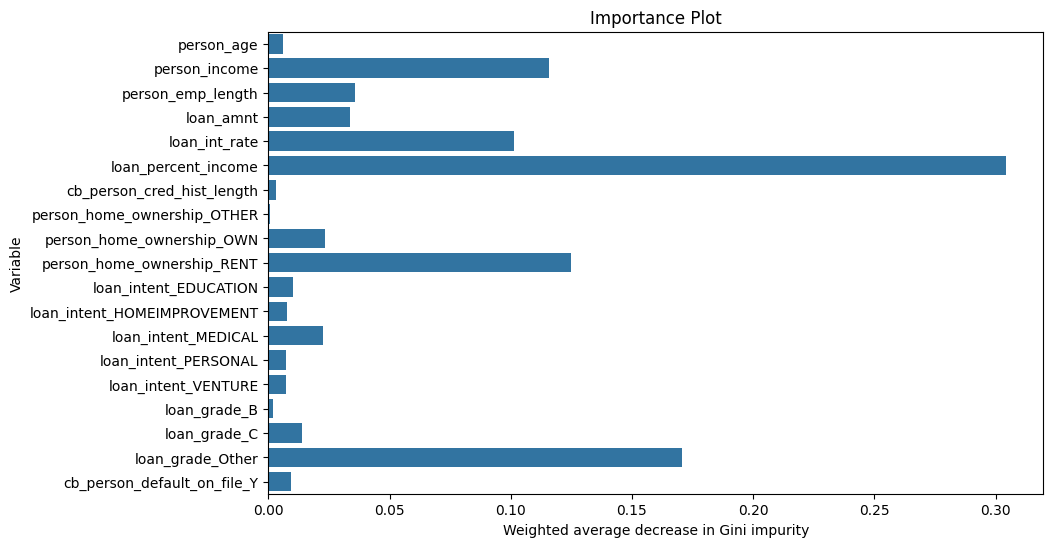

In [156]:
importances = rf_mod.feature_importances_
cols_list = X_train.columns.to_list()
importances_list = list(importances)

plt.figure(figsize=(10,6))
sns.barplot(y=cols_list,x=importances_list)
plt.title('Importance Plot')
plt.ylabel('Variable')
plt.xlabel('Weighted average decrease in Gini impurity')
plt.show()